In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Show all columns when printing DataFrames
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [2]:
# 1. Config: File paths & column names 


HISTORICAL_DATA_PATH = "C:/Users/ASUS/Downloads/historical_data.csv"      
FEAR_GREED_PATH      = "C:/Users/ASUS/Downloads/fear_greed_index.csv"     

# ---- Trader dataset columns ----
ACCOUNT_COL   = "Account"
SYMBOL_COL    = "Coin"
PRICE_COL     = "Execution Price"
SIZE_COL      = "Size Tokens"
USD_COL       = "Size USD"
SIDE_COL      = "Side"
TIME_COL      = "Timestamp IST"      # "02-12-2024 22:50"
PNL_COL       = "Closed PnL"
DIRECTION_COL = "Direction"
FEE_COL       = "Fee"
TRADE_TS_COL  = "Timestamp"          # epoch in ms (not strictly needed)

# leverage not present in this export, but we keep a name for compatibility
LEVERAGE_COL  = "leverage"           

# ---- Fear & Greed columns ----
FG_TS_COL     = "timestamp"          # epoch seconds
FG_VALUE_COL  = "value"
FG_CLASS_COL  = "classification"
FG_DATE_COL   = "date"               # "01-02-2018" etc (DD-MM-YYYY)


In [3]:
# 2. Load Data

trades = pd.read_csv(HISTORICAL_DATA_PATH)
print("Trades shape:", trades.shape)
print(trades.head())

print("\nColumns in trades:")
print(list(trades.columns))

fg = pd.read_csv(FEAR_GREED_PATH)
print("\nFear/Greed shape:", fg.shape)
print(fg.head())

print("\nColumns in Fear/Greed:")
print(list(fg.columns))


Trades shape: (211224, 16)
                                      Account  Coin  Execution Price  Size Tokens  Size USD Side     Timestamp IST  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769       986.87   7872.16  BUY  02-12-2024 22:50   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800        16.00    127.68  BUY  02-12-2024 22:50   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855       144.09   1150.63  BUY  02-12-2024 22:50   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874       142.98   1142.04  BUY  02-12-2024 22:50   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894         8.73     69.75  BUY  02-12-2024 22:50   

   Start Position Direction  Closed PnL                                   Transaction Hash     Order ID  Crossed  \
0        0.000000       Buy         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630     True   
1      986.524596       Buy     

In [4]:
# 3. Basic Cleaning & Preprocessing

trades[TIME_COL] = pd.to_datetime(
    trades[TIME_COL],
    format="%d-%m-%Y %H:%M",
    errors="coerce"
)
trades["date"] = trades[TIME_COL].dt.date

# Closed PnL as numeric
trades[PNL_COL] = pd.to_numeric(trades[PNL_COL], errors="coerce")

# Tokens / USD as numeric
for col in [SIZE_COL, USD_COL, PRICE_COL, FEE_COL]:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors="coerce")

# Notional per trade (approx USD exposure)
trades["notional"] = trades[PRICE_COL] * trades[SIZE_COL].abs()

print("\nSample cleaned trades:")
cols_preview = [
    ACCOUNT_COL, SYMBOL_COL, PRICE_COL, SIZE_COL, USD_COL,
    SIDE_COL, TIME_COL, "date", PNL_COL, FEE_COL
]
print(trades[cols_preview].head())



Sample cleaned trades:
                                      Account  Coin  Execution Price  Size Tokens  Size USD Side       Timestamp IST  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769       986.87   7872.16  BUY 2024-12-02 22:50:00   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800        16.00    127.68  BUY 2024-12-02 22:50:00   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855       144.09   1150.63  BUY 2024-12-02 22:50:00   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874       142.98   1142.04  BUY 2024-12-02 22:50:00   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894         8.73     69.75  BUY 2024-12-02 22:50:00   

         date  Closed PnL       Fee  
0  2024-12-02         0.0  0.345404  
1  2024-12-02         0.0  0.005600  
2  2024-12-02         0.0  0.050431  
3  2024-12-02         0.0  0.050043  
4  2024-12-02         0.0  0.003055  


In [9]:
# 4. Prepare Fear/Greed Data & Merge with Trades  (FINAL FIX)

# 4.1 Ensure trades["date"] is a proper datetime64[ns] (no timezone, no time)
trades["date"] = pd.to_datetime(trades["date"], errors="coerce").dt.normalize()
print("Trades date dtype:", trades["date"].dtype)
print(trades[["date"]].head())

# 4.2 Build clean datetime from UNIX timestamp (NO utc=True here)
fg["fg_datetime"] = pd.to_datetime(fg[FG_TS_COL], unit="s", errors="coerce")
fg["date"] = fg["fg_datetime"].dt.normalize()

fg_simple = fg[["date", FG_CLASS_COL]].drop_duplicates()

print("\nFear/Greed simplified:")
print(fg_simple.head())
print("Fear/Greed date dtype:", fg_simple["date"].dtype)

# 4.3 Merge on the cleaned datetime "date" column (both are datetime64[ns])
merged = trades.merge(
    fg_simple,
    on="date",
    how="left"
)

print("\nMerged shape:", merged.shape)
print(merged[[ACCOUNT_COL, SYMBOL_COL, "date", FG_CLASS_COL, PNL_COL]].head())

missing_sentiment_pct = merged[FG_CLASS_COL].isna().mean() * 100
print(f"\n% of trades without mapped sentiment: {missing_sentiment_pct:.2f}%")


Trades date dtype: datetime64[ns]
        date
0 2024-12-02
1 2024-12-02
2 2024-12-02
3 2024-12-02
4 2024-12-02

Fear/Greed simplified:
        date classification
0 2018-02-01           Fear
1 2018-02-02   Extreme Fear
2 2018-02-03           Fear
3 2018-02-04   Extreme Fear
4 2018-02-05   Extreme Fear
Fear/Greed date dtype: datetime64[ns]

Merged shape: (211224, 19)
                                      Account  Coin       date classification  Closed PnL
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107 2024-12-02  Extreme Greed         0.0
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107 2024-12-02  Extreme Greed         0.0
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107 2024-12-02  Extreme Greed         0.0
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107 2024-12-02  Extreme Greed         0.0
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107 2024-12-02  Extreme Greed         0.0

% of trades without mapped sentiment: 0.00%


In [6]:
# 5. Helper: Risk / Performance Metrics Function

def compute_risk_metrics(group: pd.DataFrame) -> pd.Series:
    pnl = group[PNL_COL].dropna()
    n_trades = len(pnl)
    if n_trades == 0:
        return pd.Series({
            "n_trades": 0,
            "total_pnl": np.nan,
            "avg_pnl": np.nan,
            "std_pnl": np.nan,
            "sharpe_like": np.nan,
            "win_rate": np.nan,
            "loss_rate": np.nan,
            "breakeven_rate": np.nan,
            "avg_notional": np.nan,
        })
    
    mean_pnl = pnl.mean()
    std_pnl = pnl.std(ddof=0)
    sharpe_like = mean_pnl / std_pnl if std_pnl not in (0, np.nan) else np.nan

    win_rate       = (pnl > 0).mean()
    loss_rate      = (pnl < 0).mean()
    breakeven_rate = (pnl == 0).mean()
    
    avg_notional = group["notional"].mean()

    return pd.Series({
        "n_trades": n_trades,
        "total_pnl": pnl.sum(),
        "avg_pnl": mean_pnl,
        "std_pnl": std_pnl,
        "sharpe_like": sharpe_like,
        "win_rate": win_rate,
        "loss_rate": loss_rate,
        "breakeven_rate": breakeven_rate,
        "avg_notional": avg_notional,
    })


In [10]:
# 6. Overall Performance vs Market Sentiment (Fear/Greed)

sentiment_trades = merged.dropna(subset=[FG_CLASS_COL])

sentiment_perf = (
    sentiment_trades
    .groupby(FG_CLASS_COL)
    .apply(compute_risk_metrics)
    .reset_index()
    .sort_values("sharpe_like", ascending=False)
)

print("Performance by Fear/Greed classification:")
print(sentiment_perf)


Performance by Fear/Greed classification:
  classification  n_trades     total_pnl    avg_pnl      std_pnl  sharpe_like  win_rate  loss_rate  breakeven_rate  \
1  Extreme Greed   39992.0  2.715171e+06  67.892861   766.818706     0.088538  0.464943   0.056486        0.478571   
4        Neutral   37686.0  1.292921e+06  34.307718   517.115359     0.066344  0.396991   0.084859        0.518150   
2           Fear   61837.0  3.357155e+06  54.290400   935.347875     0.058043  0.420768   0.061274        0.517959   
3          Greed   50303.0  2.150129e+06  42.743559  1116.017297     0.038300  0.384828   0.115659        0.499513   
0   Extreme Fear   21400.0  7.391102e+05  34.537862  1136.029548     0.030402  0.370607   0.115654        0.513738   

   avg_notional  
1   3112.251531  
4   4782.732642  
2   7816.109965  
3   5736.884385  
0   5349.731778  


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23904\3518644295.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_risk_metrics)


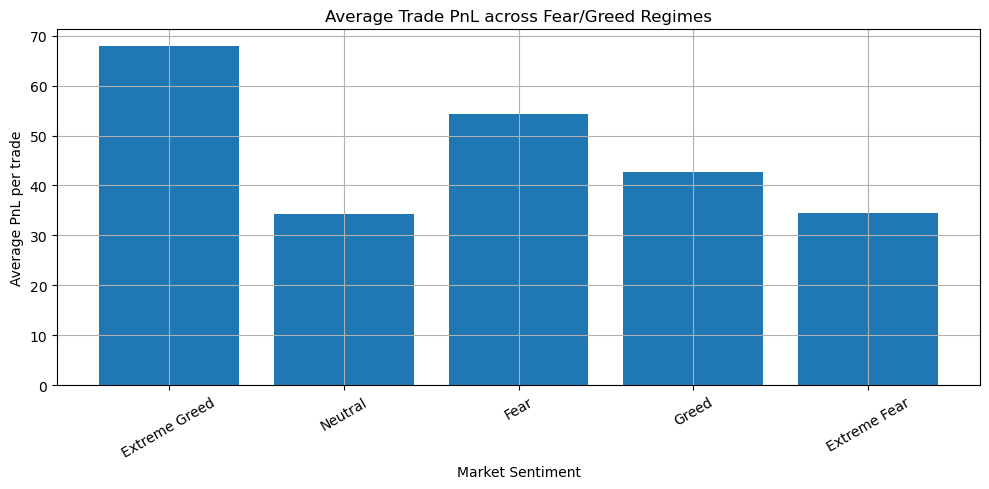

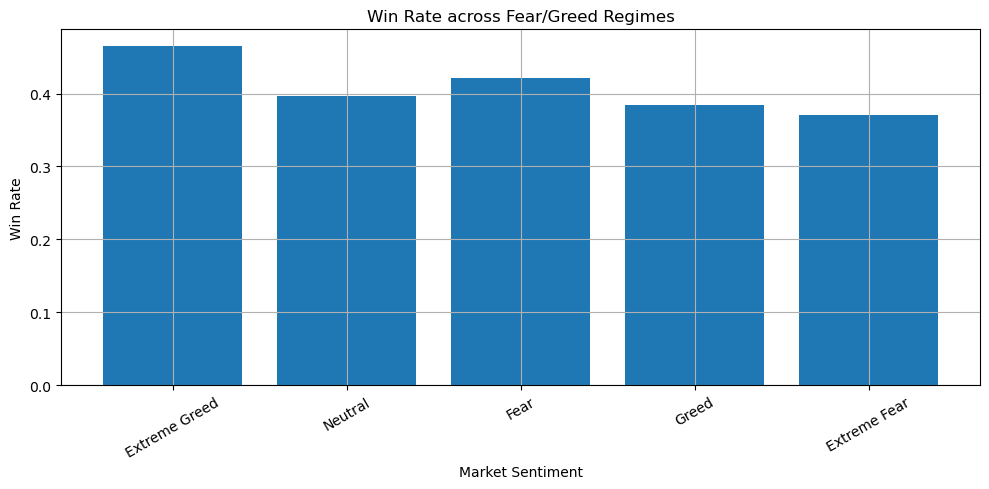

<Figure size 1000x500 with 0 Axes>

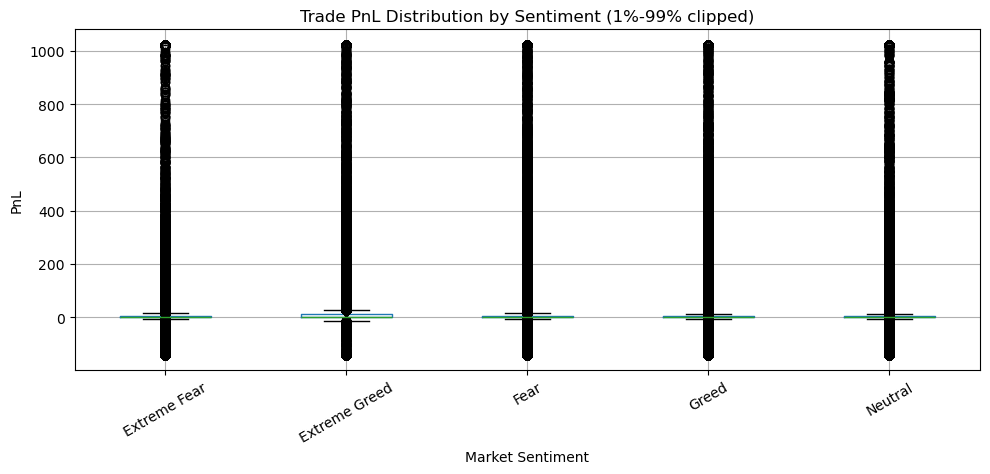

In [11]:
# 7. Visualizations: PnL vs Sentiment

# Average PnL barplot
plt.figure()
plt.bar(sentiment_perf[FG_CLASS_COL], sentiment_perf["avg_pnl"])
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL per trade")
plt.title("Average Trade PnL across Fear/Greed Regimes")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Win rate barplot
plt.figure()
plt.bar(sentiment_perf[FG_CLASS_COL], sentiment_perf["win_rate"])
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.title("Win Rate across Fear/Greed Regimes")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Boxplot of PnL by sentiment (clipped to avoid huge outliers)
pnl_clip = sentiment_trades.copy()
lower = pnl_clip[PNL_COL].quantile(0.01)
upper = pnl_clip[PNL_COL].quantile(0.99)
pnl_clip[PNL_COL] = pnl_clip[PNL_COL].clip(lower, upper)

plt.figure()
pnl_clip.boxplot(column=PNL_COL, by=FG_CLASS_COL)
plt.suptitle("")
plt.title("Trade PnL Distribution by Sentiment (1%-99% clipped)")
plt.xlabel("Market Sentiment")
plt.ylabel("PnL")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [12]:
# 8. Trader Behavior: Which Traders Thrive in Fear vs Greed?

acc_sentiment_perf = (
    sentiment_trades
    .groupby([ACCOUNT_COL, FG_CLASS_COL])
    .apply(compute_risk_metrics)
    .reset_index()
)

print("Account-level performance per sentiment:")
print(acc_sentiment_perf.head())

best_regime_per_account = (
    acc_sentiment_perf
    .sort_values(["Account", "avg_pnl"], ascending=[True, False])
    .groupby(ACCOUNT_COL)
    .head(1)
    .reset_index(drop=True)
)

print("\nBest sentiment regime per account (by avg_pnl):")
print(best_regime_per_account[[ACCOUNT_COL, FG_CLASS_COL, "avg_pnl", "sharpe_like", "n_trades"]].head())


Account-level performance per sentiment:
                                      Account classification  n_trades     total_pnl      avg_pnl       std_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012   Extreme Fear     100.0  1.247692e+05  1247.692214  11462.536756   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Greed     945.0 -4.028234e+04   -42.626810   1288.805396   
2  0x083384f897ee0f19899168e3b1bec365f52a9012           Fear    1778.0  1.113374e+06   626.194346   4690.226371   
3  0x083384f897ee0f19899168e3b1bec365f52a9012          Greed     574.0  2.767193e+05   482.089321   7046.315502   
4  0x083384f897ee0f19899168e3b1bec365f52a9012        Neutral     421.0  1.256501e+05   298.456334   1804.753421   

   sharpe_like  win_rate  loss_rate  breakeven_rate  avg_notional  
0     0.108850  0.370000   0.000000        0.630000  15071.008913  
1    -0.033075  0.066667   0.193651        0.739683  12080.270431  
2     0.133510  0.526434   0.064679        0.408886  17020.49493

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23904\905702057.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_risk_metrics)


In [13]:
# 9. Symbol-level Patterns: Are Some Markets More Sensitive?

symbol_sentiment_perf = (
    sentiment_trades
    .groupby([SYMBOL_COL, FG_CLASS_COL])
    .apply(compute_risk_metrics)
    .reset_index()
)

print("Symbol-level performance per sentiment:")
print(symbol_sentiment_perf.head())

if "Greed" in symbol_sentiment_perf[FG_CLASS_COL].unique():
    top_symbols_greed = (
        symbol_sentiment_perf[symbol_sentiment_perf[FG_CLASS_COL] == "Greed"]
        .sort_values("avg_pnl", ascending=False)
        .head(10)
    )
    print("\nTop symbols during 'Greed' by avg_pnl:")
    print(top_symbols_greed[[SYMBOL_COL, "avg_pnl", "sharpe_like", "n_trades"]])


Symbol-level performance per sentiment:
  Coin classification  n_trades   total_pnl    avg_pnl    std_pnl  sharpe_like  win_rate  loss_rate  breakeven_rate  \
0   @1  Extreme Greed      27.0  495.667559  18.358058  51.789593     0.354474  0.407407   0.148148        0.444444   
1   @1           Fear       1.0    0.000000   0.000000   0.000000          NaN  0.000000   0.000000        1.000000   
2   @1          Greed       6.0    1.078679   0.179780  27.007344     0.006657  0.333333   0.166667        0.500000   
3  @10   Extreme Fear       2.0   -0.063484  -0.031742   0.031742    -1.000000  0.000000   0.500000        0.500000   
4  @10           Fear       1.0    0.000000   0.000000   0.000000          NaN  0.000000   0.000000        1.000000   

   avg_notional  
0    117.140862  
1      0.577808  
2     83.049557  
3     18.628585  
4      0.000277  

Top symbols during 'Greed' by avg_pnl:
      Coin     avg_pnl  sharpe_like  n_trades
16    @109  416.218936     2.079590      13.0
586  

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23904\3879048757.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_risk_metrics)


Daily PnL with sentiment:
        date classification  Closed PnL
0 2023-05-01          Greed    0.000000
1 2023-12-05  Extreme Greed    0.000000
2 2023-12-14          Greed -205.434737
3 2023-12-15          Greed  -24.632034
4 2023-12-16          Greed    0.000000


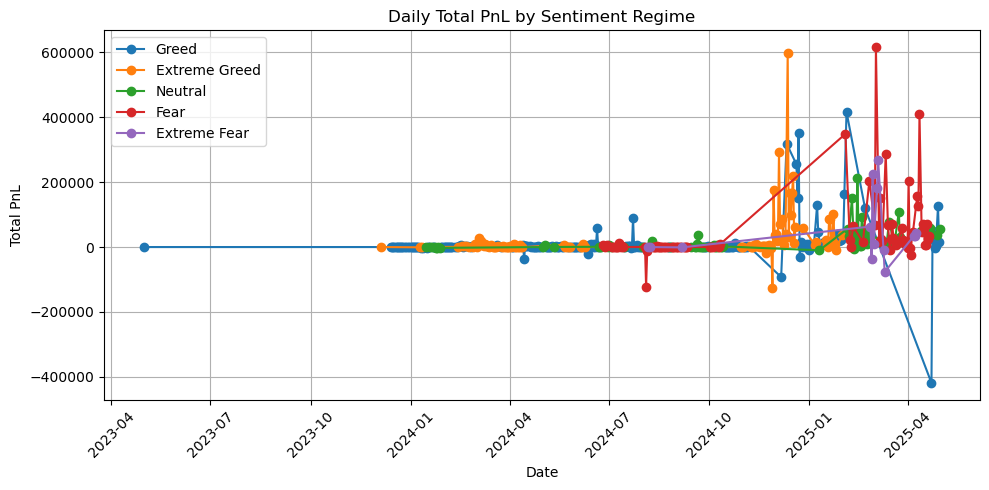

In [14]:
# 10. Time-Series View: Daily PnL vs Sentiment

daily_pnl = (
    merged
    .groupby(["date", FG_CLASS_COL])[PNL_COL]
    .sum()
    .reset_index()
    .sort_values("date")
)

print("Daily PnL with sentiment:")
print(daily_pnl.head())

plt.figure()
for sentiment in daily_pnl[FG_CLASS_COL].dropna().unique():
    subset = daily_pnl[daily_pnl[FG_CLASS_COL] == sentiment]
    plt.plot(subset["date"], subset[PNL_COL], marker="o", linestyle="-", label=sentiment)

plt.xlabel("Date")
plt.ylabel("Total PnL")
plt.title("Daily Total PnL by Sentiment Regime")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# 11. Export Key Tables for Report / Portfolio

sentiment_perf.to_csv("sentiment_performance_summary.csv", index=False)
acc_sentiment_perf.to_csv("account_sentiment_performance.csv", index=False)
symbol_sentiment_perf.to_csv("symbol_sentiment_performance.csv", index=False)

print("Exported:")
print("- sentiment_performance_summary.csv")
print("- account_sentiment_performance.csv")
print("- symbol_sentiment_performance.csv")


Exported:
- sentiment_performance_summary.csv
- account_sentiment_performance.csv
- symbol_sentiment_performance.csv


In [16]:
# 12. Quick Text Summary Helper 

print("=== High-level Insights Snapshot ===\n")

print("1) Regime comparison (avg_pnl, sharpe_like, win_rate):")
print(
    sentiment_perf[[FG_CLASS_COL, "avg_pnl", "sharpe_like", "win_rate", "n_trades"]]
    .sort_values("sharpe_like", ascending=False)
)

print("\n2) Example: top accounts & their best regime:")
print(
    best_regime_per_account[[ACCOUNT_COL, FG_CLASS_COL, "avg_pnl", "sharpe_like", "n_trades"]]
    .head(10)
)


=== High-level Insights Snapshot ===

1) Regime comparison (avg_pnl, sharpe_like, win_rate):
  classification    avg_pnl  sharpe_like  win_rate  n_trades
1  Extreme Greed  67.892861     0.088538  0.464943   39992.0
4        Neutral  34.307718     0.066344  0.396991   37686.0
2           Fear  54.290400     0.058043  0.420768   61837.0
3          Greed  42.743559     0.038300  0.384828   50303.0
0   Extreme Fear  34.537862     0.030402  0.370607   21400.0

2) Example: top accounts & their best regime:
                                      Account classification      avg_pnl  sharpe_like  n_trades
0  0x083384f897ee0f19899168e3b1bec365f52a9012   Extreme Fear  1247.692214     0.108850     100.0
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  Extreme Greed    43.222903     0.193159     825.0
2  0x271b280974205ca63b716753467d5a371de622ab  Extreme Greed   358.632043     0.583422       5.0
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4  Extreme Greed    14.437904     0.152557    7481.0
4  0x2c22